In [1]:
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import numpy as np

### Forecast energy supply for the next two days 

Long-term forecasts not the issue, rather short-term, intra-day supplies

What was the supply today, controlling for weather, use that as a starting point to forecast the next two days

Requires forecasting weather and other short-term effects affecting supply

In [2]:
def datetime_range(start, end, delta):
    '''Need to create time date series'''
    current = start
    while current < end:
        yield current
        current += delta
        
dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
       datetime_range(datetime(2020, 4, 1, 0), datetime(2021, 4, 1, 0), 
       timedelta(minutes=15))]

              Total
count  35040.000000
mean      39.316823
std       65.282022
min        0.000000
25%        0.000000
50%        0.362500
75%       60.577500
max      360.375000
Date      object
Total    float64
dt        object
dtype: object


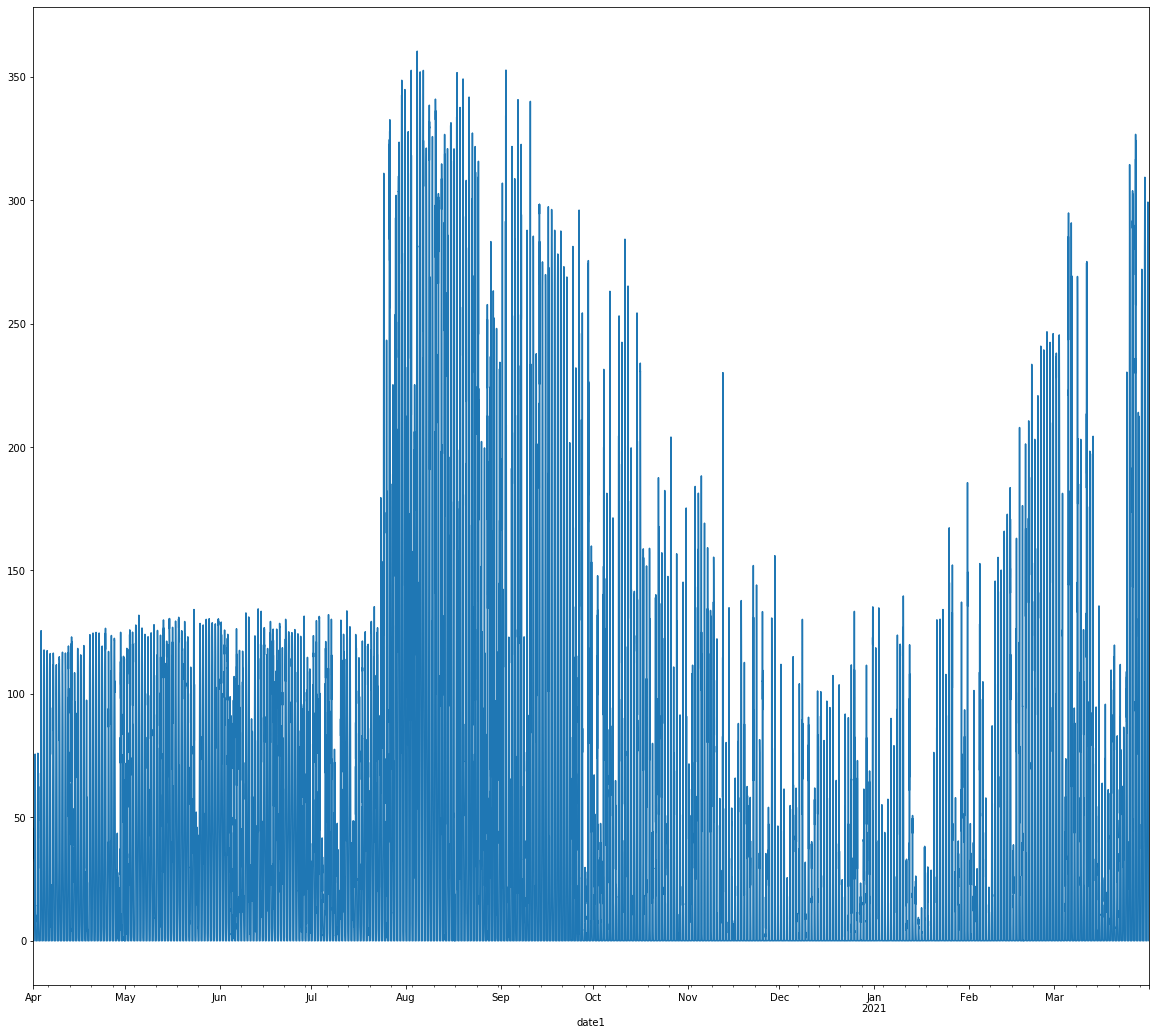

In [3]:
#read in data
dt1 = pd.read_csv('../data/production_raw.csv', dayfirst = True, parse_dates=False, date_parser='DateTime')
dt1.rename(columns = {'DateTime': 'Date'}, inplace = True)
dt1['dt'] = dts
dt1['date1'] = pd.to_datetime(dt1['dt'])
dt1.set_index('date1', inplace = True)

dt1['Total'].plot(figsize = (20, 18))

print(dt1.describe())
print(dt1.dtypes)


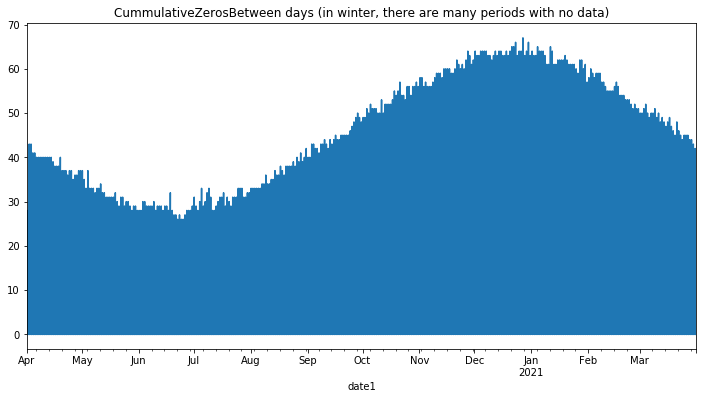

In [4]:
# cmZeros
a = dt1['Total'].shift().eq(0)
b = a.cumsum()
dt1['CmZerosBetween'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmZerosBetween'].iloc[0:].plot(figsize = (12, 6), title = "CummulativeZerosBetween days (in winter, there are many periods with no data)")

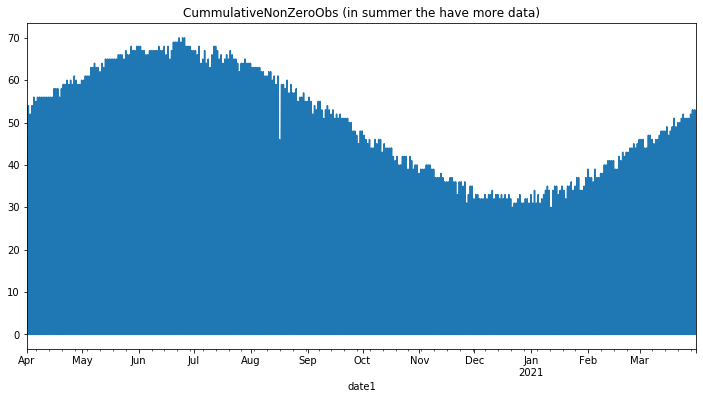

In [5]:
# cmNonZeros
a = dt1['Total'].ne(0)
b = a.cumsum()
dt1['CmNonZeros'] = b.sub(b.mask(a).ffill().fillna(0)).astype(int)
dt1['CmNonZeros'].iloc[0:].plot(figsize = (12, 6), title = 'CummulativeNonZeroObs (in summer the have more data)')

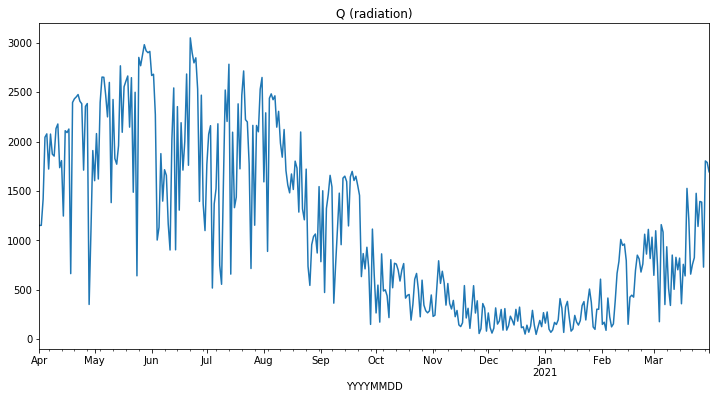

In [6]:
rad1 = pd.read_csv('../data/Radiation.csv', sep = ';')
rad1['YYYYMMDD'] = pd.to_datetime(rad1['YYYYMMDD'],  format='%Y%m%d')
rad1.set_index('YYYYMMDD', inplace = True, drop = True)
rad1.columns = rad1.columns.str.strip()

# select range
start_date = '2020-04-01'
end_date   = '2021-03-31'
rad1['Day'] = rad1.index.floor('D')
rad1.head()
mask = (rad1['Day'] >= start_date) & (rad1['Day'] <= end_date)
rad2 = rad1[mask]
rad2.head()

rad2['Q'].plot(figsize = (12, 6), title = 'Q (radiation)')

In [7]:
import pmdarima
from pmdarima.arima import ADFTest
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [9]:
dt1.head()

,Date,Total,dt,CmZerosBetween,CmNonZeros
date1,,,,,
2020-04-01 00:00:00,01/04/2020 00:00,0.0,2020-04-01 00:00,0,0
2020-04-01 00:15:00,01/04/2020 00:15,0.0,2020-04-01 00:15,1,0
2020-04-01 00:30:00,01/04/2020 00:30,0.0,2020-04-01 00:30,2,0
2020-04-01 00:45:00,01/04/2020 00:45,0.0,2020-04-01 00:45,3,0
2020-04-01 01:00:00,01/04/2020 01:00,0.0,2020-04-01 01:00,4,0


In [19]:
trc = dt1[['Total']]
trc

,Total
date1,
2020-04-01 00:00:00,0.0
2020-04-01 00:15:00,0.0
2020-04-01 00:30:00,0.0
2020-04-01 00:45:00,0.0
2020-04-01 01:00:00,0.0
...,...
2021-03-31 22:45:00,0.0
2021-03-31 23:00:00,0.0
2021-03-31 23:15:00,0.0


In [25]:
lastNumObs = 500
subset1 = trc[-lastNumObs:]
exog1 = np.where(subset1['Total'] != 0, 0, 1)

print(len(subset1))

500


In [26]:
test_size = 24
train = subset1[:-test_size]
y = train.values
exogTrain = subset1[:-test_size]
print(len(y))
train_size = len(train)
print(train_size)
test = subset1[-test_size:]
exogTest = subset1[-test_size:]
print(len(test))

476
476
24


In [27]:
24*4

96

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = subset1 #pm.datasets.load_wineind()
train, test = train_test_split(y, train_size = train_size)

# Fit your model
model = pm.auto_arima(train, exog=exogTrain, seasonal=True, m=96, stepwise=True, trace=True)

Performing stepwise search to minimize aic


In [18]:
# make your forecasts
forecasts = model.predict(test.shape[0], exogenous = exogTest)  # predict N steps into the future

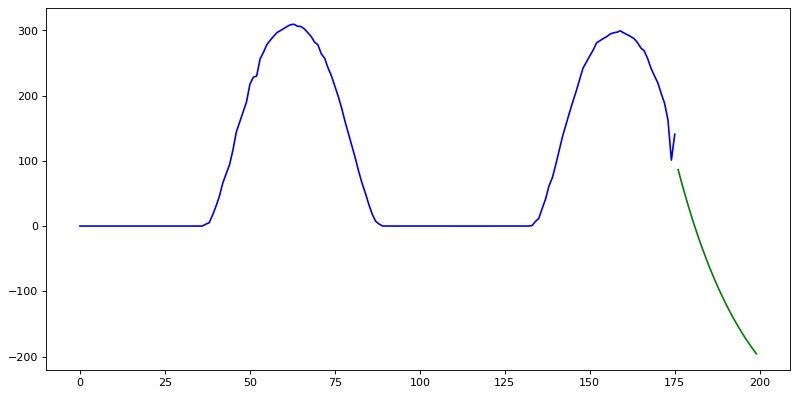

In [19]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize=(12, 6), dpi=80)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.show()

,Total
date1,
2021-03-31 11:30:00,260.7425
2021-03-31 11:45:00,269.9100
2021-03-31 12:00:00,280.8325
2021-03-31 12:15:00,284.1375
2021-03-31 12:30:00,287.5025
2021-03-31 12:45:00,290.3825
2021-03-31 13:00:00,294.3500
2021-03-31 13:15:00,296.2350
2021-03-31 13:30:00,297.1700


In [448]:
sub1 = trc[-20:]
print(sub1)
test_size = 5
train = sub1[:-test_size]
print(train)
test = sub1[-test_size:]
test

                       Total
date1                       
2021-03-31 19:00:00  25.2275
2021-03-31 19:15:00  18.3750
2021-03-31 19:30:00   7.8150
2021-03-31 19:45:00   3.5325
2021-03-31 20:00:00   0.1775
2021-03-31 20:15:00   0.0000
2021-03-31 20:30:00   0.0000
2021-03-31 20:45:00   0.0000
2021-03-31 21:00:00   0.0000
2021-03-31 21:15:00   0.0000
2021-03-31 21:30:00   0.0000
2021-03-31 21:45:00   0.0000
2021-03-31 22:00:00   0.0000
2021-03-31 22:15:00   0.0000
2021-03-31 22:30:00   0.0000
2021-03-31 22:45:00   0.0000
2021-03-31 23:00:00   0.0000
2021-03-31 23:15:00   0.0000
2021-03-31 23:30:00   0.0000
2021-03-31 23:45:00   0.0000
                       Total
date1                       
2021-03-31 19:00:00  25.2275
2021-03-31 19:15:00  18.3750
2021-03-31 19:30:00   7.8150
2021-03-31 19:45:00   3.5325
2021-03-31 20:00:00   0.1775
2021-03-31 20:15:00   0.0000
2021-03-31 20:30:00   0.0000
2021-03-31 20:45:00   0.0000
2021-03-31 21:00:00   0.0000
2021-03-31 21:15:00   0.0000
2021-03-31 21:

,Total
date1,
2021-03-31 22:45:00,0.0
2021-03-31 23:00:00,0.0
2021-03-31 23:15:00,0.0
2021-03-31 23:30:00,0.0
2021-03-31 23:45:00,0.0


In [441]:
split = 5
train_size = len(trc[-5000:1])

In [440]:
4*24*2

192

#### 

In [437]:
y_train = trc[0:].values

In [438]:
arima_model = pmdarima.auto_arima(y_train, start_p=2, d=0, start_q=0, max_p=3, max_d=2, max_q=3, seasonal=False)
order = arima_model.order
order

(2, 0, 3)

In [431]:
predDataFrame['ARIMA'] = pd.DataFrame(arima_model.predict(n_periods = predPeriod-1), index = y_test.index).values

# predict based on model
model2 =  sm.tsa.arima.ARIMA(y_train, order=order).fit()

KeyboardInterrupt: 

In [ ]:
model2

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [418]:
trc.values
trc.index

DatetimeIndex(['2020-04-01 00:00:00', '2020-04-01 00:15:00',
               '2020-04-01 00:30:00', '2020-04-01 00:45:00',
               '2020-04-01 01:00:00', '2020-04-01 01:15:00',
               '2020-04-01 01:30:00', '2020-04-01 01:45:00',
               '2020-04-01 02:00:00', '2020-04-01 02:15:00',
               ...
               '2021-03-31 21:30:00', '2021-03-31 21:45:00',
               '2021-03-31 22:00:00', '2021-03-31 22:15:00',
               '2021-03-31 22:30:00', '2021-03-31 22:45:00',
               '2021-03-31 23:00:00', '2021-03-31 23:15:00',
               '2021-03-31 23:30:00', '2021-03-31 23:45:00'],
              dtype='datetime64[ns]', name='date1', length=35040, freq=None)

In [422]:
X = trc.index
#X = np.reshape(X, (len(X), 1))
y = trc.values
X

DatetimeIndex(['2020-04-01 00:00:00', '2020-04-01 00:15:00',
               '2020-04-01 00:30:00', '2020-04-01 00:45:00',
               '2020-04-01 01:00:00', '2020-04-01 01:15:00',
               '2020-04-01 01:30:00', '2020-04-01 01:45:00',
               '2020-04-01 02:00:00', '2020-04-01 02:15:00',
               ...
               '2021-03-31 21:30:00', '2021-03-31 21:45:00',
               '2021-03-31 22:00:00', '2021-03-31 22:15:00',
               '2021-03-31 22:30:00', '2021-03-31 22:45:00',
               '2021-03-31 23:00:00', '2021-03-31 23:15:00',
               '2021-03-31 23:30:00', '2021-03-31 23:45:00'],
              dtype='datetime64[ns]', name='date1', length=35040, freq=None)

In [423]:
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.legend(['data', 'trend'])
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=['2020-04-01T00:00:00.000000000' '2020-04-01T00:15:00.000000000'
 '2020-04-01T00:30:00.000000000' ... '2021-03-31T23:15:00.000000000'
 '2021-03-31T23:30:00.000000000' '2021-03-31T23:45:00.000000000'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [389]:
import statsmodels.api as sm
from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)


dt1['Q'] = np.repeat(rad2.values[:,0], 24 * 4, axis=0)
# Fit and summarize OLS model
dt1.head()
dt1['Q_2'] = dt1['Q'] * dt1['Q']
dt1['Q_3'] = dt1['Q_2'] * dt1['Q']

In [390]:
exog1 = dt1[['Q', 'Q_2', 'Q_3']].values
exog1 = np.array(exog1, dtype=float)
exog1

array([[1.15100000e+03, 1.32480100e+06, 1.52484595e+09],
       [1.15100000e+03, 1.32480100e+06, 1.52484595e+09],
       [1.15100000e+03, 1.32480100e+06, 1.52484595e+09],
       ...,
       [1.69400000e+03, 2.86963600e+06, 4.86116338e+09],
       [1.69400000e+03, 2.86963600e+06, 4.86116338e+09],
       [1.69400000e+03, 2.86963600e+06, 4.86116338e+09]])

In [391]:
exog1 = sm.add_constant(exog1, prepend=True)

endog1 = dt1['Total'].values

mod = sm.OLS(endog1, exog1)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     1299.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:41:40   Log-Likelihood:            -1.9429e+05
No. Observations:               35040   AIC:                         3.886e+05
Df Residuals:                   35036   BIC:                         3.886e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5215      1.058     -0.493      0.6

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from numpy import polyfit

series = dt1['Total'].values
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
	value = coef[-1]
	for d in range(degree):
		value += X[i]**(degree-d) * coef[d]
	curve.append(value)
# plot curve over original data
pyplot.plot(series.values)
pyplot.plot(curve, color='red', linewidth=3)
pyplot.show()

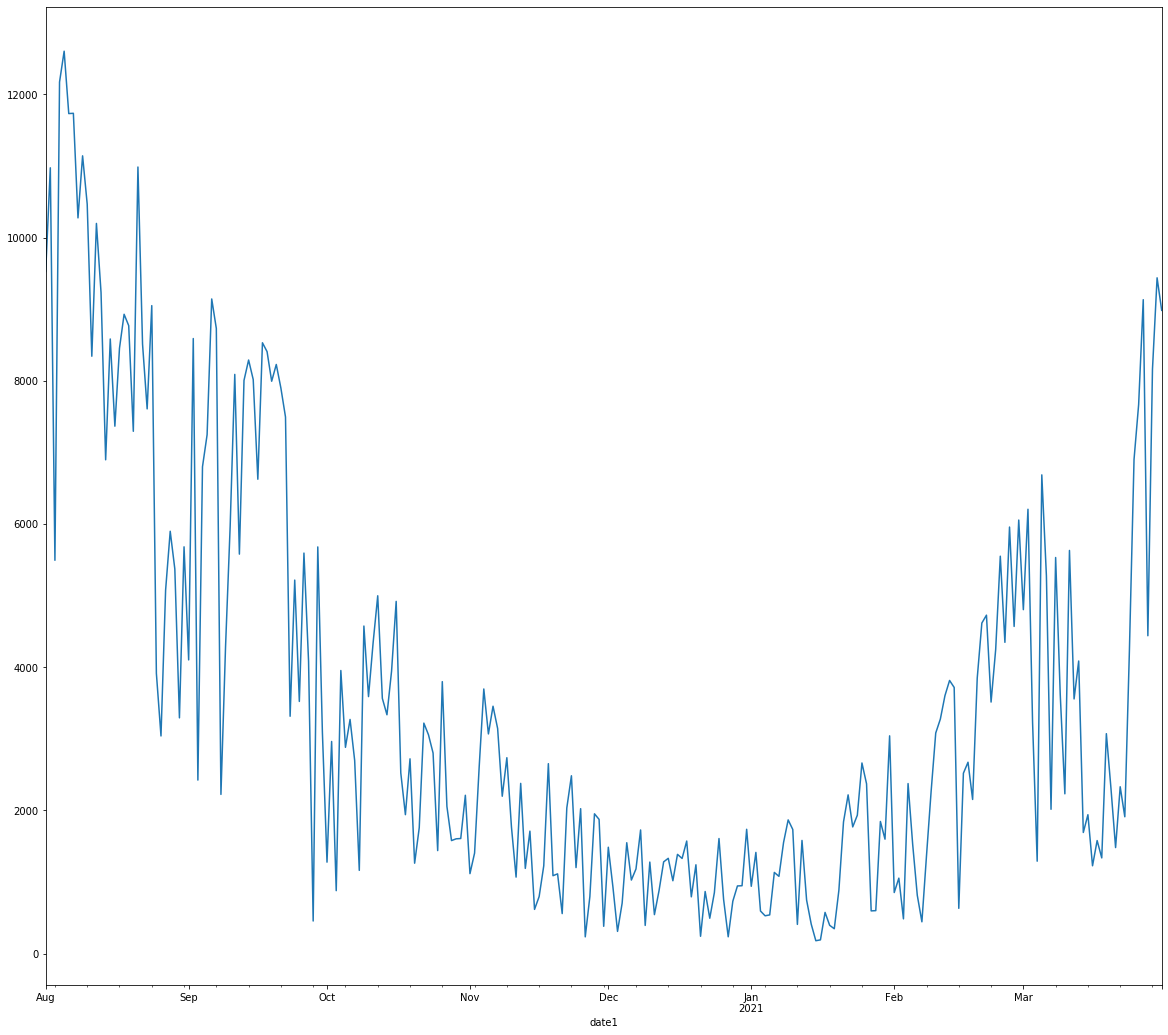

In [311]:
dt2 = dt1[dt1.index >= '2020-08-01']
dtMonth = dt2.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

### What are interday patterns, do they change through time?

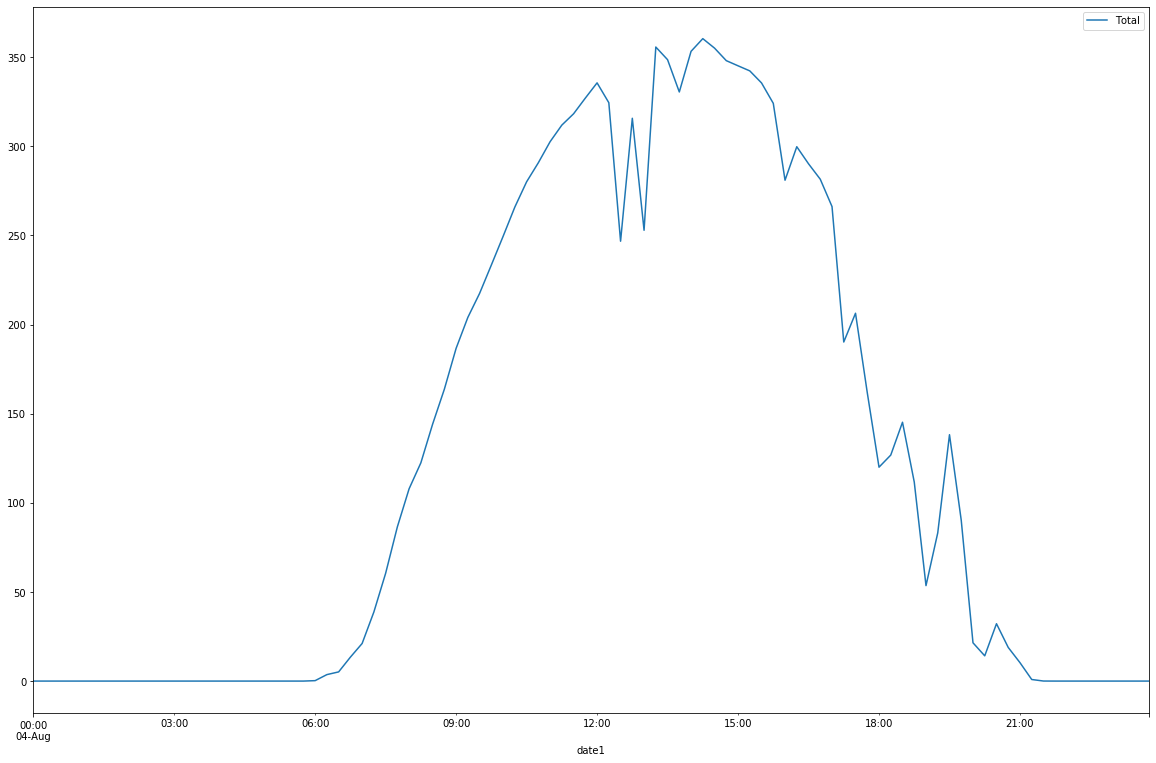

In [221]:
dt3 = dt1.drop(columns = ['Date', 'dt', 'CmZerosBetween', 'CmNonZeros'])
dt3.head()
dt3['2020-08-04'].plot(figsize = (20, 13))

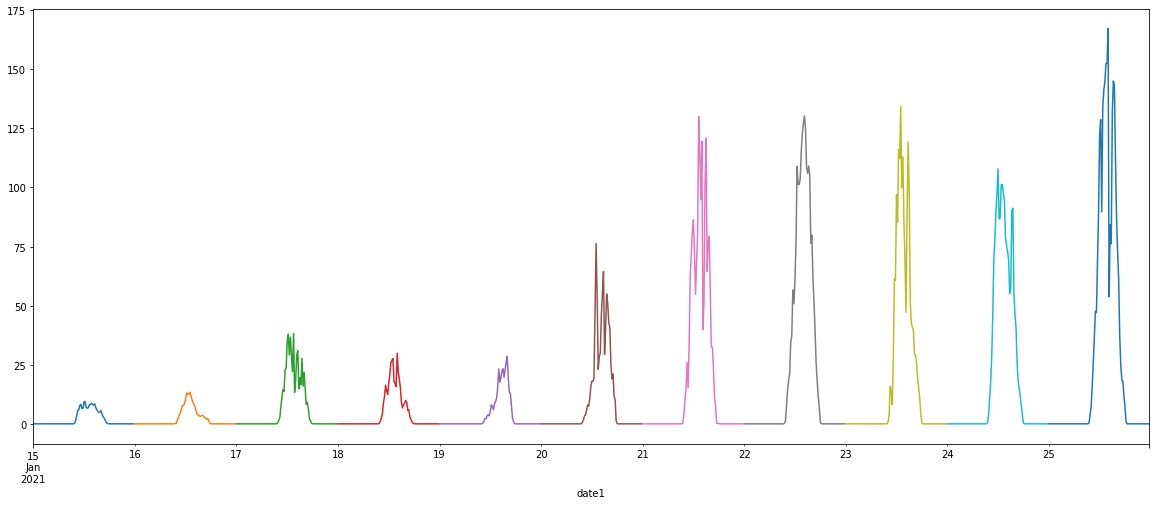

In [231]:
dt3['Day'] = dt3.index.floor('D')

start_date = '2021-01-15'
end_date   = '2021-01-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))
    

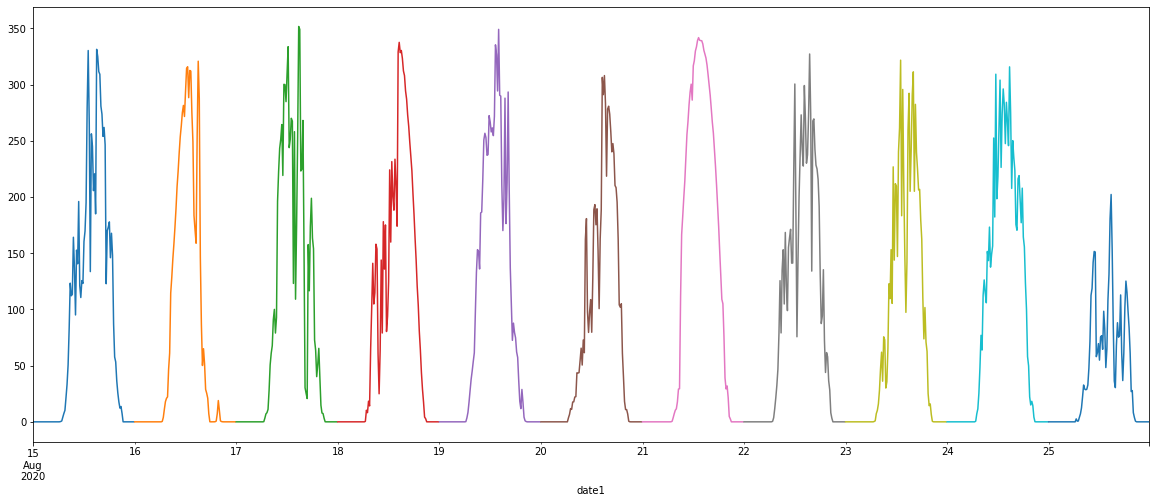

In [230]:
start_date = '2020-08-15'
end_date   = '2020-08-25'

mask = (dt3['Day'] >= start_date) & (dt3['Day'] <= end_date)
dt4 = dt3[mask]

grp1 = dt4.groupby('Day')

for key, dat in grp1:
    dat['Total'].plot(figsize = (20, 8))

### Split data

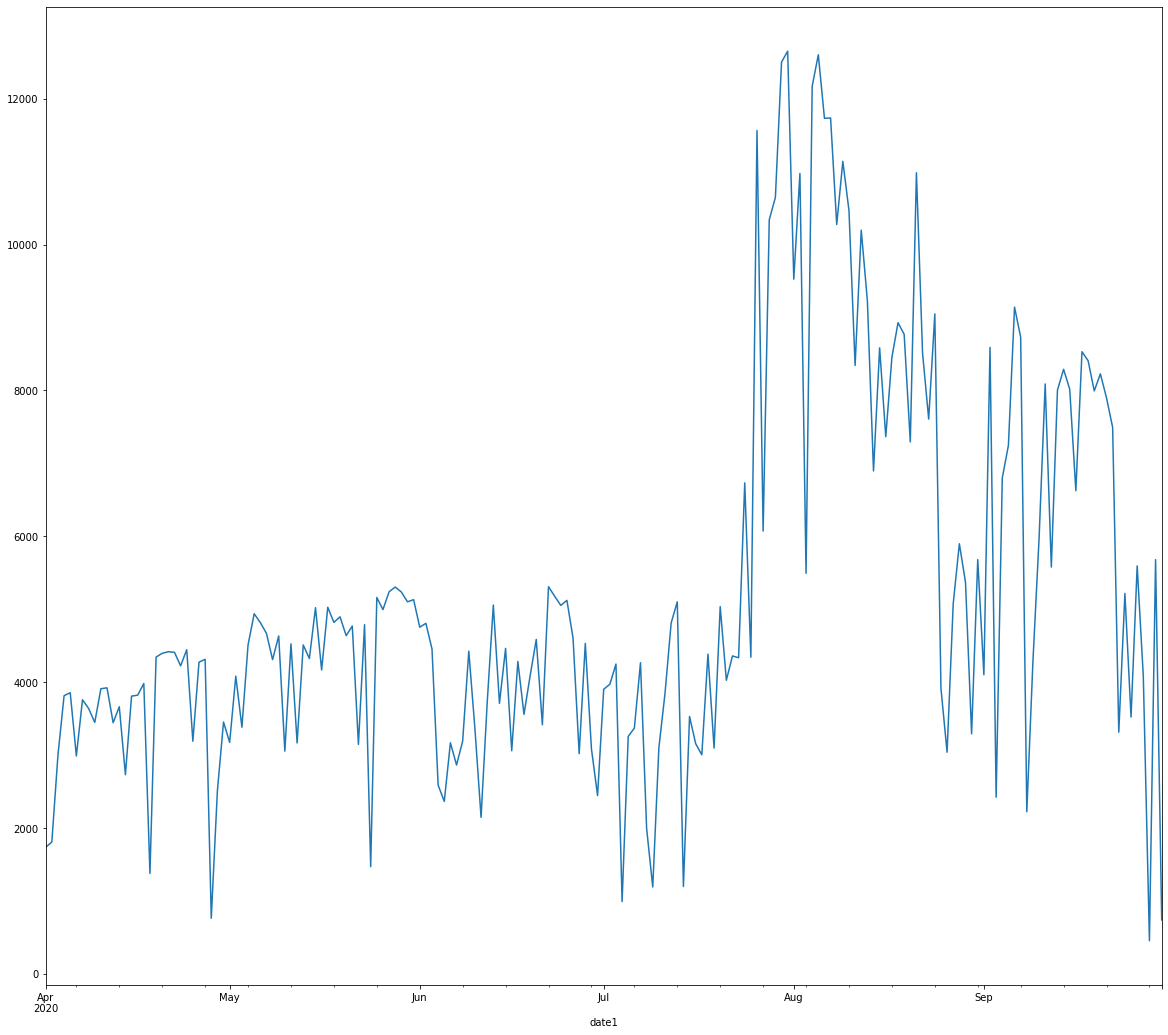

In [11]:
split = int(len(dt1) * 0.5)
train = dt1.iloc[:split].copy()
dtMonth = train.groupby(pd.Grouper(freq='D')).sum()
dtMonth['Total'].plot(figsize = (20, 18))

In [12]:
# Add a dummy for data until Aug

In [13]:
qdata = pd.read_csv('../data/Radiation.csv', sep = ';')
qdata

,YYYYMMDD,Q
0,20200101,123
1,20200102,80
2,20200103,77
3,20200104,246
4,20200105,79
...,...,...
739,20220109,227
740,20220110,218
741,20220111,386
742,20220112,180


In [14]:
pd.to_datetime(qdata['YYYYMMDD'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')

0      2020-01-01
1      2020-01-02
2      2020-01-03
3      2020-01-04
4      2020-01-05
          ...    
739    2022-01-09
740    2022-01-10
741    2022-01-11
742    2022-01-12
743    2022-01-13
Name: YYYYMMDD, Length: 744, dtype: object